# **DEEP LEARNING PROJECT**
**IMAGE CAPTIONING**

KELOMPOK 9:
1. Kent Amadeo Timotheus - 2702227025
2. Theodore Zachary - 2702244100
3. Renaldo - 2702235670

DATASET: Flickr8k Dataset for image captioning.

LINK KAGGLE : https://www.kaggle.com/datasets/adityajn105/flickr8k



# **IMPORT LIBRARIES & SETUP**

In [ ]:
import os
import math
import pickle
import re
from textwrap import wrap
from tqdm import tqdm
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding, LSTM, Bidirectional,
                                     Dropout, Concatenate, Layer)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.efficientnet import (
    EfficientNetB2,
    preprocess_input as effnet_preprocess
)

# Metrics (nltk)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

In [ ]:
path = kagglehub.dataset_download("adityajn105/flickr8k")
print(path)
print(os.listdir(path))

Using Colab cache for faster access to the 'flickr8k' dataset.
/kaggle/input/flickr8k
['captions.txt', 'Images']


In [ ]:
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Dataset downloaded to:", path)


IMAGES_DIR = "/kaggle/input/flickr8k/Images"
CAPTION_FILE = "/kaggle/input/flickr8k/captions.txt"

print("Using captions file:", CAPTION_FILE)
print("Images directory exists:", os.path.exists(IMAGES_DIR))

Using Colab cache for faster access to the 'flickr8k' dataset.
Dataset downloaded to: /kaggle/input/flickr8k
Using captions file: /kaggle/input/flickr8k/captions.txt
Images directory exists: True


In [ ]:
import pandas as pd

def load_flickr8k_captions(filepath):
    image_ids = []
    captions = []

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()

            # skip empty or broken lines
            if len(line) < 10:
                continue

            # skip potential header lines
            if line.lower().startswith("image"):
                continue

            # split image and caption
            if "\t" in line:
                img_id, caption = line.split("\t")
            elif "," in line:
                img_id, caption = line.split(",", 1)
            else:
                parts = line.split(" ", 1)
                if len(parts) != 2:
                    continue
                img_id, caption = parts

            img_id = img_id.split("#")[0].strip()

            if not img_id.endswith(".jpg"):
                continue

            image_ids.append(img_id)
            captions.append(caption.strip())

    df = pd.DataFrame({"image": image_ids, "caption": captions})
    return df


data = load_flickr8k_captions(CAPTION_FILE)
print(data.head())
print("Total captions:", len(data))

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
Total captions: 40455


In [ ]:
img_size = 260   # penting: konsisten di semua pemanggilan

def readImage(path, image_size=img_size):
    img = load_img(path, target_size=(image_size, image_size))
    img = img_to_array(img)
    img = effnet_preprocess(img)
    return img

def display_images(temp_df, image_path, image_size=img_size):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(15, 15))
    n = 0
    for i in range(min(len(temp_df), 15)):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(os.path.join(image_path, temp_df['image'][i]), image_size=image_size)
        img_disp = (image - image.min()) / (image.max() - image.min())
        plt.imshow(img_disp.astype(np.float32))
        plt.title("\n".join(wrap(temp_df['caption'][i], 25)))
        plt.axis('off')
    plt.show()

def text_preprocessing(df, caption_col='caption'):
    df[caption_col] = df[caption_col].astype(str).str.strip()
    df[caption_col] = df[caption_col].str.lower()
    df[caption_col] = df[caption_col].apply(
        lambda x: re.sub(r"[^a-z0-9\s\.,'!?-]", "", x)
    )
    df[caption_col] = df[caption_col].apply(
        lambda x: "startseq " + x.strip() + " endseq"
    )
    return df


In [ ]:
# ==== apply preprocessing ====
data = text_preprocessing(data)

captions = data['caption'].tolist()

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab size: {vocab_size}")

max_length = max(len(c.split()) for c in captions)
print(f"Max caption length: {max_length}")

images = data['image'].unique().tolist()
nimages = len(images)
print(f"Number of unique images: {nimages}")

split_index = round(nimages * 0.85)
train_images = images[:split_index]
val_images   = images[split_index:]

train = data[data['image'].isin(train_images)].reset_index(drop=True)
val   = data[data['image'].isin(val_images)].reset_index(drop=True)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


Vocab size: 8496
Max caption length: 40
Number of unique images: 8091


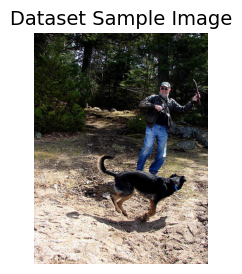

Ground Truth Captions:
1. a man plays fetch with his big black dog just out of the woods .
2. a man prepares to throw a stick intended for a black dog in front of him to fetch .
3. a man throwing a stick for his black and tan dog .
4. man throwing stick and dog watching
5. the man in the black jacket is throwing a stick for the dog to chase .


In [ ]:
import matplotlib.pyplot as plt
import os
import random

def show_image_with_captions(
    df,
    image_path,
    image_col="image",
    caption_col="caption",
    n_captions=5
):
    """
    Menampilkan 1 gambar + n caption ground truth
    """

    # pilih 1 image random
    image_id = random.choice(df[image_col].unique().tolist())

    # ambil caption untuk image tersebut
    captions = df[df[image_col] == image_id][caption_col].tolist()
    captions = captions[:n_captions]

    # bersihkan startseq & endseq
    captions = [
        c.replace("startseq", "").replace("endseq", "").strip()
        for c in captions
    ]

    # load image
    img = plt.imread(os.path.join(image_path, image_id))

    # plot
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Dataset Sample Image", fontsize=14)
    plt.show()

    # print captions
    print("Ground Truth Captions:")
    for i, cap in enumerate(captions, 1):
        print(f"{i}. {cap}")

show_image_with_captions(
    df=data,
    image_path=IMAGES_DIR,
    n_captions=5
)

In [ ]:
base_model = EfficientNetB2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)

outputs = base_model.get_layer('block6a_expand_activation').output
fe_model = Model(inputs=base_model.input, outputs=outputs)

features = {}
for image in tqdm(data['image'].unique(), desc="Extracting features (EffNetB2 block6)"):
    img = readImage(os.path.join(IMAGES_DIR, image), image_size=img_size)
    img = np.expand_dims(img, axis=0)
    feat_map = fe_model.predict(img, verbose=0)[0]   # (H, W, C)
    h, w, c = feat_map.shape
    features[image] = feat_map.reshape(-1, c).astype(np.float32)

sample_feature = next(iter(features.values()))
num_patches, feat_dim = sample_feature.shape
print("\nnum_patches:", num_patches, "feat_dim:", feat_dim)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Extracting features (EffNetB2 block6): 100%|██████████| 8091/8091 [11:30<00:00, 11.72it/s]


num_patches: 289 feat_dim: 720


In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

class CustomDataGenerator(Sequence):
    def __init__(
        self, df, X_col, y_col, batch_size,
        tokenizer, vocab_size, max_length,
        features_dict, shuffle=True, **kwargs
    ):
        super().__init__(**kwargs)   # <- hilangkan warning PyDataset

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features_dict
        self.shuffle = shuffle
        self.n = len(self.df)

        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))

    @property
    def num_batches(self):
        return self.__len__()

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = [], [], []

        for _, row in batch.iterrows():
            image   = row[self.X_col]
            caption = row[self.y_col]
            feature = self.features[image]  # (num_patches, feat_dim)

            seq = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq  = seq[:i]
                out_seq = seq[i]          # ← INTEGER LABEL

                in_seq = pad_sequences(
                    [in_seq],
                    maxlen=self.max_length,
                    padding='post'
                )[0]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        X1 = np.array(X1, dtype=np.float32)
        X2 = np.array(X2, dtype=np.int32)
        y  = np.array(y,  dtype=np.int32)   # ← INTEGER
        return X1, X2, y


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = [encoder_shape, decoder_shape]
        self.W1 = Dense(self.units)
        self.W2 = Dense(self.units)
        self.V  = Dense(1)
        super().build(input_shape)

    def call(self, inputs):
        encoder_features, decoder_hidden = inputs
        decoder_hidden = tf.expand_dims(decoder_hidden, 1)

        score = tf.nn.tanh(
            self.W1(encoder_features) +
            self.W2(decoder_hidden)
        )

        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = tf.reduce_sum(
            attention_weights * encoder_features, axis=1
        )

        return context_vector, tf.squeeze(attention_weights, -1)


In [ ]:
num_patches = sample_feature.shape[0]
feat_dim    = sample_feature.shape[1]

encoder_input = Input(shape=(num_patches, feat_dim), name='image_features')
decoder_input = Input(shape=(max_length,),           name='decoder_input')

embedding_dim = 512
embed = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    mask_zero=True,
    name='embed'
)(decoder_input)

# BiLSTM 256
bi_lstm = Bidirectional(
    LSTM(
        256,
        return_sequences=False,
        return_state=False
    ),
    name='bilstm'
)(embed)

# bilstm_1 = Bidirectional(
#     LSTM(
#         512,
#         return_sequences=True,
#         dropout=0.3,
#         recurrent_dropout=0.0
#     ),
#     name='bilstm_1'
# )(embed)

# bilstm_2 = Bidirectional(
#     LSTM(
#         512,
#         return_sequences=False,
#         dropout=0.3,
#         recurrent_dropout=0.0
#     ),
#     name='bilstm_2'
# )(bilstm_1)


# Attention units
attention_units = 512
attention = BahdanauAttention(attention_units)
context_vector, att_weights = attention([encoder_input, bi_lstm])

# Concatenate context + decoder hidden
concat = Concatenate(axis=-1)([context_vector, bi_lstm])   # (batch, feat_dim + 512)

# Dense layer yang juga dikecilkan (256 -> 128)
x = Dense(512, activation='relu')(concat)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[encoder_input, decoder_input], outputs=outputs)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        clipnorm=5.0
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 40, 512)   │  4,349,952 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ decoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_1            │ (None, 40, 1024)  │  4,198,400 │ embed[0][0],      │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 289, 720)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_2            │ (None, 1024)      │  6,295,552 │ bilstm_1[0][0],   │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 720),     │    894,465 │ image_features[0… │
│ (BahdanauAttention) │ (None, 289)]      │            │ bilstm_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1744)      │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ bilstm_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    893,440 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8496)      │  2,183,472 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,946,609 (72.28 MB)

 Trainable params: 18,946,609 (72.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 64

train_generator = CustomDataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=batch_size,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features_dict=features,
    shuffle=True
)

validation_generator = CustomDataGenerator(
    df=val,
    X_col='image',
    y_col='caption',
    batch_size=batch_size,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features_dict=features,
    shuffle=False
)

model_name = "caption_trained_model_effb2.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.2,
    min_lr=1e-9,
    verbose=1
)

history = caption_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr],
    verbose=1
)

Epoch 1/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - loss: 6.2392 - sparse_categorical_accuracy: 0.1348
Epoch 1: val_loss improved from inf to 4.50931, saving model to caption_trained_model_effb2.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 490s 892ms/step - loss: 6.2377 - sparse_categorical_accuracy: 0.1348 - val_loss: 4.5093 - val_sparse_categorical_accuracy: 0.2467 - learning_rate: 1.0000e-04
Epoch 2/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - loss: 4.4916 - sparse_categorical_accuracy: 0.2489
Epoch 2: val_loss improved from 4.50931 to 4.10629, saving model to caption_trained_model_effb2.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 474s 881ms/step - loss: 4.4914 - sparse_categorical_accuracy: 0.2490 - val_loss: 4.1063 - val_sparse_categorical_accuracy: 0.2809 - learning_rate: 1.0000e-04
Epoch 3/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - loss: 4.1720 - sparse_categorical_accuracy: 0.2746
Epoch 3: val_loss improved from 4.10629 to 3.95295, saving model to caption_trained_model_effb2.keras
538

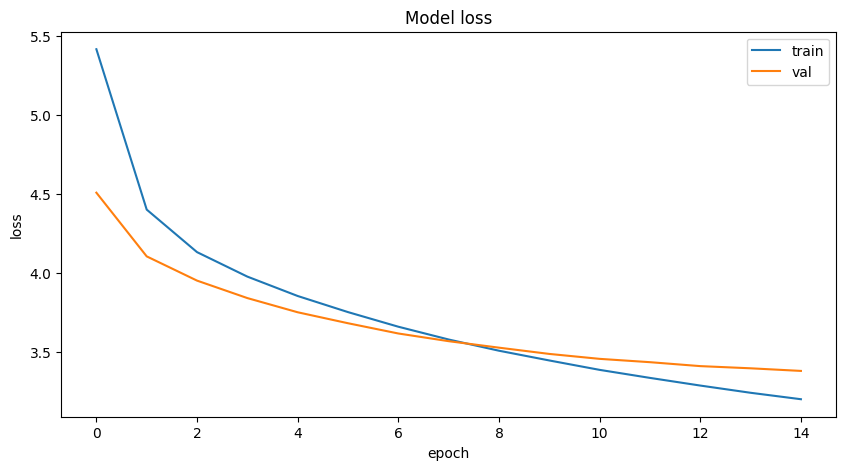

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'],     label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def clean_caption(raw_caption):
    caption = raw_caption.replace('startseq', '').replace('endseq', '').strip()
    caption = caption.capitalize()
    if not caption.endswith('.'):
        caption = caption + '.'
    return caption

def beam_search_predictions(model, tokenizer, feature, max_length, beam_index=3):
    start_token = tokenizer.word_index.get('startseq')
    end_token   = tokenizer.word_index.get('endseq')
    if start_token is None or end_token is None:
        raise ValueError("startseq/endseq tokens missing in tokenizer")

    sequences = [[[start_token], 0.0]]  # ([token_ids], log_prob)

    smoothie = None  # kalau mau smoothing BLEU nanti, di sini tidak dipakai

    while True:
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end_token or len(seq) >= max_length:
                all_candidates.append((seq, score))
                continue

            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            yhat = model.predict(
                [feature[np.newaxis, ...], sequence],
                verbose=0
            )[0]  # (vocab_size,)

            top_indices = np.argsort(yhat)[-beam_index:]

            for idx in top_indices:
                prob = yhat[idx]
                if prob <= 0:
                    continue
                candidate_seq   = seq + [int(idx)]
                candidate_score = score + math.log(prob + 1e-10)
                all_candidates.append((candidate_seq, candidate_score))

        ordered   = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_index]

        if any(s[-1] == end_token for s, _ in sequences):
            break

        if len(sequences[0][0]) >= max_length:
            break

    best_seq = sequences[0][0]
    words = [idx_to_word(i, tokenizer) for i in best_seq]
    caption = " ".join([w for w in words if w is not None])
    return clean_caption(caption)

def predict_caption_beam(model, image_key, tokenizer, max_length, features_dict, beam_index=3):
    feature = features_dict[image_key]
    return beam_search_predictions(model, tokenizer, feature, max_length, beam_index=beam_index)


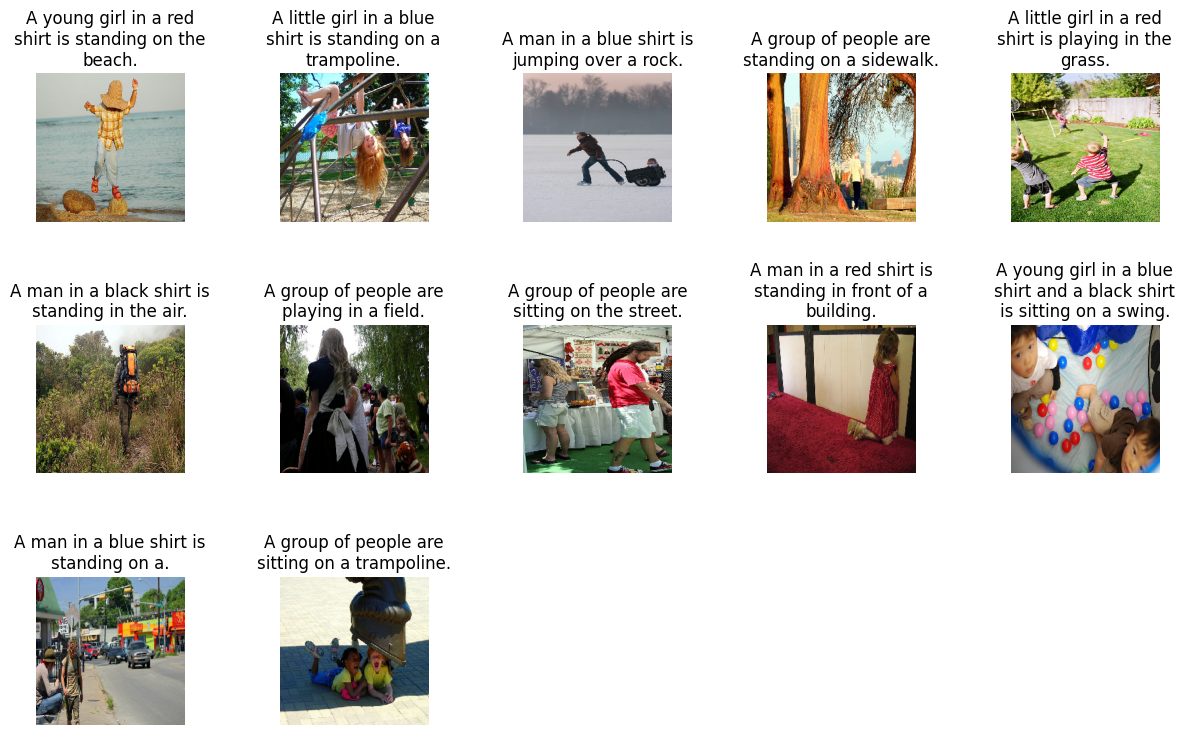

In [ ]:
samples = val.sample(12).reset_index(drop=True)
samples['pred_caption'] = ""

for idx, row in samples.iterrows():
    pred = predict_caption_beam(
        caption_model,
        row['image'],
        tokenizer,
        max_length,
        features,
        beam_index=3
    )
    samples.at[idx, 'pred_caption'] = pred

# untuk display pakai kolom pred_caption
samples_disp = samples.copy()
samples_disp['caption'] = samples_disp['pred_caption']
display_images(samples_disp, IMAGES_DIR, image_size=img_size)


In [ ]:
def lcs_length(x, y):
    m, n = len(x), len(y)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m):
        for j in range(n):
            if x[i] == y[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

def rouge_l_score(reference_tokens_list, hypothesis_tokens):
    """
    reference_tokens_list: list of token list (multi reference)
    hypothesis_tokens: list of tokens
    """
    best_f = 0.0
    for ref in reference_tokens_list:
        lcs = lcs_length(ref, hypothesis_tokens)
        if lcs == 0:
            continue
        prec = lcs / len(hypothesis_tokens)
        rec  = lcs / len(ref)
        if prec + rec == 0:
            f = 0.0
        else:
            f = (2 * prec * rec) / (prec + rec)
        best_f = max(best_f, f)
    return best_f


In [ ]:
def build_idf(references_per_image):
    """
    references_per_image: dict[image_id] -> list of token list (references)
    """
    df = Counter()
    N = len(references_per_image)
    for refs in references_per_image.values():
        # gabungkan semua caption ref per image
        words = set()
        for r in refs:
            words.update(r)
        for w in words:
            df[w] += 1

    idf = {}
    for w, c in df.items():
        idf[w] = math.log((N + 1) / (c + 1)) + 1.0
    return idf

def cider_like_score(ref_tokens_list, hyp_tokens, idf):
    """
    Sederhana: cosine similarity tf-idf unigram
    """
    tf_ref = Counter()
    tf_hyp = Counter()

    for ref in ref_tokens_list:
        tf_ref.update(ref)
    tf_hyp.update(hyp_tokens)

    # tf-idf vector
    ref_vec = {}
    hyp_vec = {}

    for w, tf in tf_ref.items():
        ref_vec[w] = tf * idf.get(w, 0.0)

    for w, tf in tf_hyp.items():
        hyp_vec[w] = tf * idf.get(w, 0.0)

    # dot product
    common = set(ref_vec.keys()) & set(hyp_vec.keys())
    dot = sum(ref_vec[w] * hyp_vec[w] for w in common)

    # norms
    ref_norm = math.sqrt(sum(v*v for v in ref_vec.values()))
    hyp_norm = math.sqrt(sum(v*v for v in hyp_vec.values()))

    if ref_norm == 0 or hyp_norm == 0:
        return 0.0
    return dot / (ref_norm * hyp_norm)


In [ ]:
def build_references(df):
    """
    df: DataFrame dengan kolom 'image' dan 'caption' (masih ada startseq/endseq)
    output: dict[image_id] -> list of token list (reference captions)
    """
    refs = defaultdict(list)
    for _, row in df.iterrows():
        img = row['image']
        cap = row['caption']
        cap = cap.replace('startseq', '').replace('endseq', '').strip()
        tokens = cap.lower().split()
        refs[img].append(tokens)
    return refs

def evaluate_caption_model(
    model, tokenizer, features_dict,
    val_df, max_length, beam_index=3
):
    # build reference tokens
    references_per_image = build_references(val_df)

    # IDF for CIDEr-like
    idf = build_idf(references_per_image)

    smoothie = SmoothingFunction().method4

    bleu1_scores, bleu2_scores = [], []
    bleu3_scores, bleu4_scores = [], []
    meteor_scores, rougeL_scores, cider_scores = [], [], []

    all_images = list(references_per_image.keys())

    for img_id in tqdm(all_images, desc="Evaluating"):
        # prediction
        hyp_caption = predict_caption_beam(
            model, img_id, tokenizer, max_length,
            features_dict, beam_index=beam_index
        )
        hyp_tokens = hyp_caption.lower().replace('.', '').split()

        ref_tokens_list = references_per_image[img_id]

        # BLEU 1-4
        bleu1 = sentence_bleu(
            ref_tokens_list, hyp_tokens,
            weights=(1, 0, 0, 0),
            smoothing_function=smoothie
        )
        bleu2 = sentence_bleu(
            ref_tokens_list, hyp_tokens,
            weights=(0.5, 0.5, 0, 0),
            smoothing_function=smoothie
        )
        bleu3 = sentence_bleu(
            ref_tokens_list, hyp_tokens,
            weights=(1/3, 1/3, 1/3, 0),
            smoothing_function=smoothie
        )
        bleu4 = sentence_bleu(
            ref_tokens_list, hyp_tokens,
            weights=(0.25, 0.25, 0.25, 0.25),
            smoothing_function=smoothie
        )

        # METEOR (pakai string)
        ref_str_list = [" ".join(r) for r in ref_tokens_list]
        hyp_str = " ".join(hyp_tokens)
        meteors = [meteor_score([r], hyp_tokens) for r in ref_tokens_list]
        meteor_val = max(meteors) if meteors else 0.0

        # ROUGE-L
        rouge_l = rouge_l_score(ref_tokens_list, hyp_tokens)

        # Simple CIDEr-like
        cider_val = cider_like_score(ref_tokens_list, hyp_tokens, idf)

        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)
        bleu4_scores.append(bleu4)
        meteor_scores.append(meteor_val)
        rougeL_scores.append(rouge_l)
        cider_scores.append(cider_val)

    print("\n=== Evaluation (validation set) ===")
    print(f"BLEU-1 : {np.mean(bleu1_scores):.4f}")
    print(f"BLEU-2 : {np.mean(bleu2_scores):.4f}")
    print(f"BLEU-3 : {np.mean(bleu3_scores):.4f}")
    print(f"BLEU-4 : {np.mean(bleu4_scores):.4f}")
    print(f"METEOR : {np.mean(meteor_scores):.4f}")
    print(f"ROUGE-L: {np.mean(rougeL_scores):.4f}")
    print(f"CIDEr* : {np.mean(cider_scores):.4f}  (simple TF-IDF version)")
    return {
        'bleu1': np.mean(bleu1_scores),
        'bleu2': np.mean(bleu2_scores),
        'bleu3': np.mean(bleu3_scores),
        'bleu4': np.mean(bleu4_scores),
        'meteor': np.mean(meteor_scores),
        'rougeL': np.mean(rougeL_scores),
        'cider_like': np.mean(cider_scores)
    }


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
metrics = evaluate_caption_model(
    caption_model,
    tokenizer,
    features,      # features hasil EffNetB2
    val,
    max_length=max_length,
    beam_index=5
)
print(metrics)

Evaluating: 100%|██████████| 1214/1214 [1:19:06<00:00,  3.91s/it]


=== Evaluation (validation set) ===
BLEU-1 : 0.5193
BLEU-2 : 0.3252
BLEU-3 : 0.2097
BLEU-4 : 0.1435
METEOR : 0.2979
ROUGE-L: 0.3613
CIDEr* : 0.2031  (simple TF-IDF version)
{'bleu1': np.float64(0.5192714875941344), 'bleu2': np.float64(0.32516949330636974), 'bleu3': np.float64(0.20973369718767415), 'bleu4': np.float64(0.14348223116785713), 'meteor': np.float64(0.2979192004014326), 'rougeL': np.float64(0.3612857679695009), 'cider_like': np.float64(0.2030756573279826)}


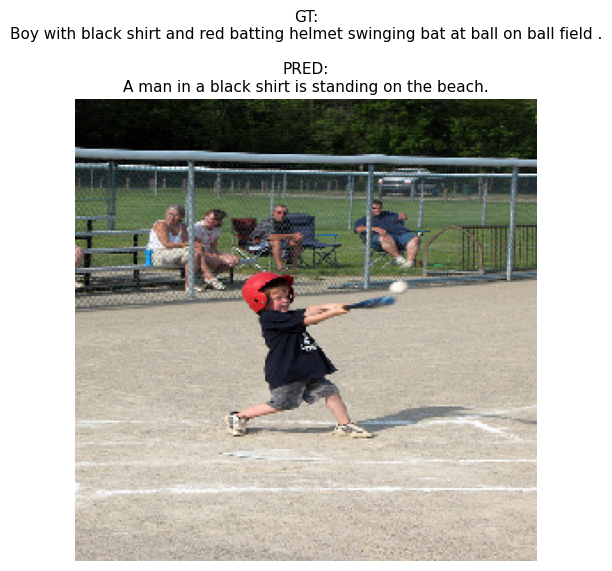

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

def clean_caption(caption):
    caption = caption.replace("startseq", "").replace("endseq", "")
    caption = caption.strip()
    caption = caption.capitalize()
    if not caption.endswith("."):
        caption += "."
    return caption

sample = val.sample(1).iloc[0]

pred_caption = predict_caption_beam(
    caption_model,
    sample['image'],
    tokenizer,
    max_length,
    features,
    beam_index=3
)

pred_caption = clean_caption(pred_caption)
true_caption = clean_caption(sample['caption'])

img_path = os.path.join(IMAGES_DIR, sample['image'])
img = load_img(img_path, target_size=(img_size,img_size))

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title(f"GT:\n{true_caption}\n\nPRED:\n{pred_caption}", fontsize=11)
plt.show()
